In [ ]:
__path__ = 'dataset'

LOAD DATA

In [3]:
import pandas as pd

In [ ]:
df = pd.read_csv(f'{__path__}/dataset.csv')
df.head()

,Unnamed: 0,text,label
0,1,ive enjoyed being able to slouch about relax a...,0
1,3,i dont know i feel so lost,0
2,5,i was beginning to feel quite disheartened,0
3,9,i can still lose the weight without feeling de...,0
4,11,im feeling a little like a damaged tree and th...,0


In [5]:
texts = df["text"].astype(str).tolist()
labels = df['label'].values

PREPROCESS

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, )
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

In [29]:
sequence_lengths = [len(seq) for seq in sequences]
max_len = int(np.percentile(sequence_lengths, 95))

# print(f"max sequence length: {max(sequence_lengths)}")
# print(f"length (persentil 95): {max_len}")

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

BUILD MODEL

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
  )

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

In [12]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
num_classes = 6

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

In [15]:
history = model.fit(
    x_train, y_train_encoded,
    validation_data=(x_test, y_test_encoded),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 155s 67ms/step - accuracy: 0.5965 - loss: 1.0314 - val_accuracy: 0.9302 - val_loss: 0.2293 - learning_rate: 0.0010
Epoch 2/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 203s 68ms/step - accuracy: 0.9252 - loss: 0.2536 - val_accuracy: 0.9404 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 3/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 199s 67ms/step - accuracy: 0.9403 - loss: 0.1822 - val_accuracy: 0.9443 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 4/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 147s 65ms/step - accuracy: 0.9421 - loss: 0.1685 - val_accuracy: 0.9422 - val_loss: 0.1671 - learning_rate: 0.0010
Epoch 5/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 148s 66ms/step - accuracy: 0.9472 - loss: 0.1450 - val_accuracy: 0.9428 - val_loss: 0.1696 - learning_rate: 0.0010
Epoch 6/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 147s 66ms/step - accuracy: 0.9495 - loss: 0.1294 - val_accuracy: 0.9437 - val_loss: 0.1825 - learning_rate: 5.0000e-04


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 100)        │     3,654,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,095,556 (42.33 MB)

 Trainable params: 3,698,518 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,397,038 (28.22 MB)

EVALUATION

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
model_loss, model_accouracy = model.evaluate(x_test, y_test_encoded)
print(f'Model Accuracy: {model_accouracy}')
print(f'Model Loss: {model_loss}')

562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9465 - loss: 0.1527
Model Accuracy: 0.9442867636680603
Model Loss: 0.15809202194213867


In [21]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion_matrix)

562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Confusion Matrix:
[[2823    9    2  100   59    1]
 [   9 2689  229   31    9   27]
 [   4   10 2964    8    4    5]
 [  13   11    1 2852  115    3]
 [   5    8    1   60 2675  246]
 [   3    7    3    6   12 2963]]


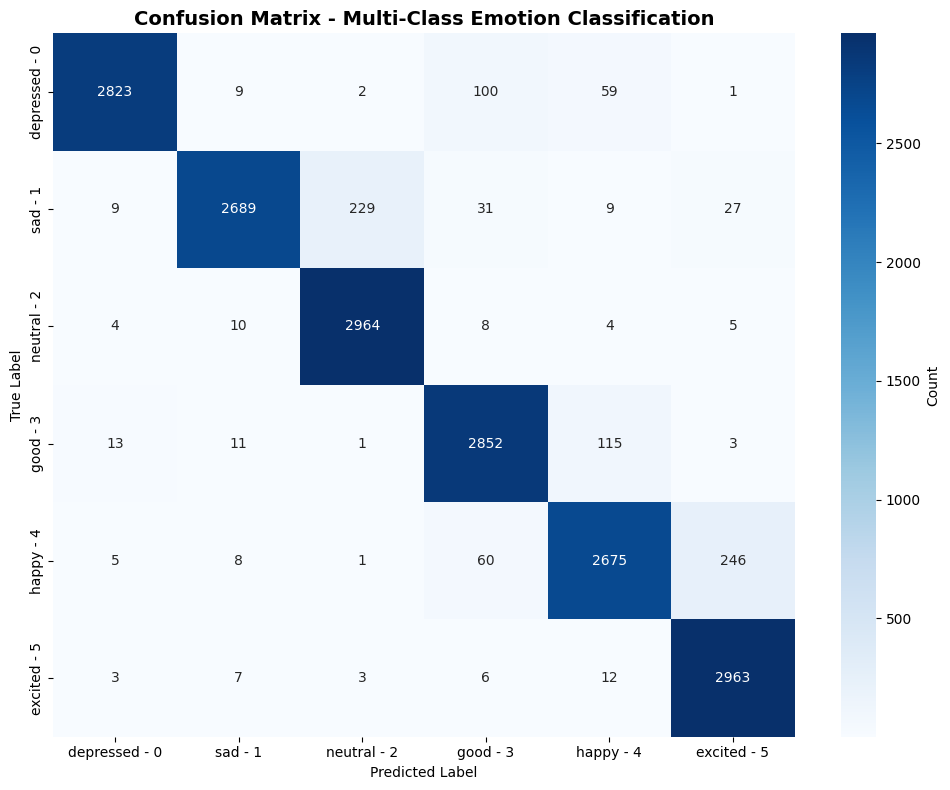

In [23]:
emotion_labels = ['depressed - 0', 'sad - 1', 'neutral - 2', 'good - 3', 'happy - 4', 'excited - 5']

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Multi-Class Emotion Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

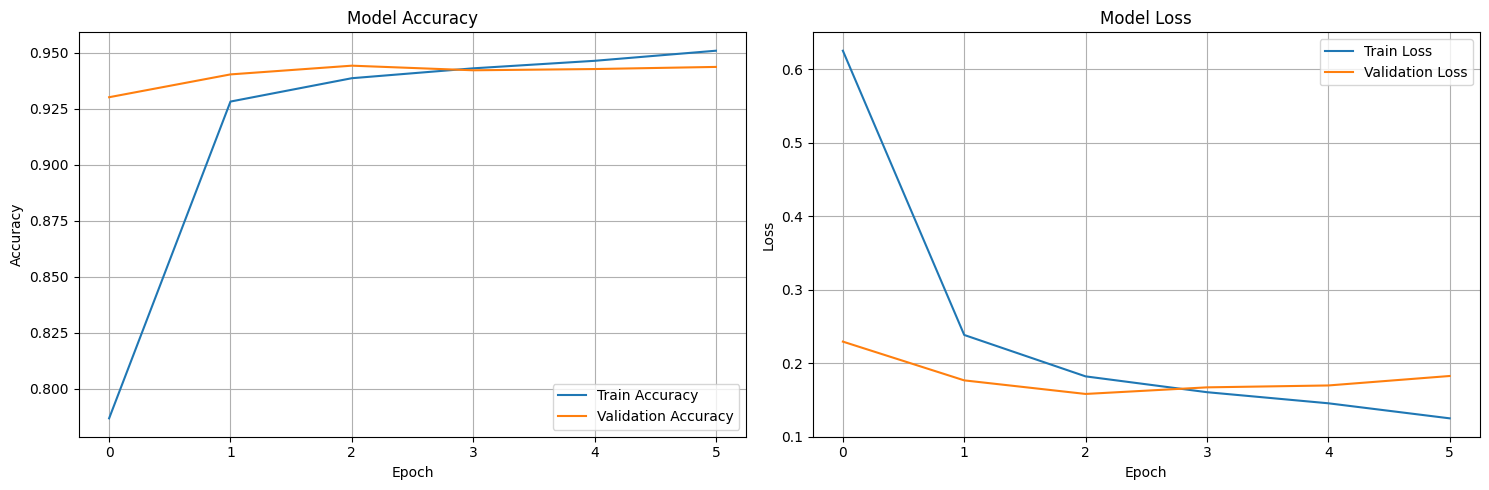

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [25]:
# per-class accuracy
for i in range(num_classes):
    class_mask = (y_test == i)
    class_accuracy = (y_pred[class_mask] == y_test[class_mask]).mean()
    class_count = np.sum(class_mask)
    print(f"{emotion_labels[i]}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {class_count} samples")

depressed - 0: 0.9429 (94.29%) - 2994 samples
sad - 1: 0.8981 (89.81%) - 2994 samples
neutral - 2: 0.9896 (98.96%) - 2995 samples
good - 3: 0.9523 (95.23%) - 2995 samples
happy - 4: 0.8932 (89.32%) - 2995 samples
excited - 5: 0.9896 (98.96%) - 2994 samples


EXPORT MODEL

In [26]:
import json

In [27]:
# convert tokenizer to JSON
tokenizer_json = tokenizer.to_json()

# create config.json

emotion_labels = ['depressed', 'sad', 'neutral', 'good', 'happy', 'excited']

config = {
    "num_words": num_words,
    "max_len": max_len,
    "vocab_size": vocab_size,
    "embedding_dim": embedding_dim,
    "num_classes": num_classes,
    "emotion_labels": emotion_labels
}

with open(f'{__path__}/config.json', 'w') as f:
    json.dump(config, f)

with open(f'{__path__}/config.json', 'w') as f:
    json.dump(config, f)

# save to file
with open(f'{__path__}/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

model.save(f'{__path__}/model.keras')

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 100)        │     3,654,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,095,556 (42.33 MB)

 Trainable params: 3,698,518 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,397,038 (28.22 MB)